In [4]:
import os
from multiprocessing import Pool
import pandas as pd
import pickle
import json
from datetime import datetime
import rdkit, scipy, sklearn
import tensorflow as tf
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import DataStructs, Descriptors
from rdkit.Chem import MACCSkeys
from rdkit import Avalon
from rdkit.Avalon import pyAvalonTools
from sklearn.metrics import accuracy_score, cohen_kappa_score, matthews_corrcoef, recall_score, precision_score,f1_score


from load_data import load_data
from write import write_config_file, write_query_to_csv, write_runs_sh, write_idx, write_training_data, write_sample_file, write_run_sample
from acquisition import select_query
from models import Tanimoto_model
from query import query


from scipy.spatial.distance import *
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline


import pandas as pd

import gpflow
from gpflow.utilities import positive
from gpflow.utilities.ops import broadcasting_elementwise
from gpflow.mean_functions import Constant
import tensorflow as tf
import reinvent_scoring


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time

In [5]:
print(os.getcwd())

/home/springnuance/reinvent-hitl/Chemists-Component-Binary-Preference


# configuration

In [6]:
experiment = 5 # options: numbers 1-5 that define which seed is used in user demo

seeds = [1718, 1896, 3975, 8355, 9774] 
seed = seeds[experiment-1]
np.random.seed(seed)
tf.random.set_seed(seed)

acquisition='thompson' #options: 'thompson', 'uncertainty', 'random', 'greedy'
READ_ONLY = False # Use 'True' to playback an existing experiment (reads queries and feedback from files instead of using the algorithm)
usecase = 'drd2'
simulated_human = True
verbose = False # print out details during interaction
loop, last_job=0, None # Do not change

In [7]:
print(os.path.exists('../Reinvent'))
print(os.path.exists('./results'))
print(os.path.exists('../../miniconda3/envs/cc_env_hitl/bin/python'))
print(os.path.exists('../../miniconda3/envs/cc_env_reinvent/bin/python'))

True
True
True
True


In [8]:
def parse_usecase(usecase):
    usecase_params = {
                          'drd2': {
                              'train_data': 'drd2_regression.train.csv',
                              'test_data': 'drd2_regression.test.csv',
                              'y_field': 'activity'
                          }
    }

    train_data_file = usecase_params[usecase]['train_data']
    test_data_file  = usecase_params[usecase]['test_data']
    y_field = usecase_params[usecase]['y_field']
    return train_data_file , test_data_file, y_field

def load_config(acquisition,seed,loop, jobid=None):
    if not jobid:
        jobid=datetime.now().strftime("%d-%m-%Y")
    else:
        jobid=jobid
    jobname = 'Task2_demo_{}'.format(acquisition)

    N0=10 # size of initial training data L
    n_restarts=2 # parameters of GP optimization
    n_batch=10    # number of molecules shown at each iteration
    n_iteration=10  # the number of iteration
    fpdim=1024 #dimension of morgan fingerprint
    step=1
    cwd=os.getcwd()
    
    #reinvent_dir = os.path.expanduser("/path/to/reinvent")
    #reinvent_env = os.path.expanduser("/path/to/conda_environment/for/Reinvent")
    #output_dir=os.path.join(cwd,"./results/{}_{}_seed_{}".format(jobname, jobid, seed))
    
    reinvent_dir = os.path.expanduser("../Reinvent")
    reinvent_env = os.path.expanduser("../../miniconda3/envs/cc_env_reinvent")
    output_dir=os.path.join(cwd,"./results/{}_{}_seed_{}".format(jobname, jobid, seed))
    
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    output_dir=os.path.join(output_dir,"./loop{}".format(loop))
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    lastloop_dir=None
    return jobid, jobname, N0, n_restarts, n_batch, n_iteration, fpdim, step, reinvent_dir, reinvent_env, output_dir, lastloop_dir

def load_data_config(usecase, lastloop_dir=None):
    train_num=10000 # sample 10.000 molecules from training dataset to U
    test_num=2000 # sample 2000 molecules from testing dataset to the test set
    data_dir= './data/'
    train_data_file , test_data_file, y_field=parse_usecase(usecase)

    test_data_path=os.path.join(data_dir,test_data_file) if test_data_file else None

    if lastloop_dir:
        train_data_path=os.path.join(lastloop_dir,train_data_file)
    else:
        train_data_path=os.path.join(data_dir,train_data_file)
    return train_num, test_num, train_data_path, test_data_path, y_field

In [9]:
def train(X_updated, y_updated, jobid, acquisition,seed,loop, iteration):
    jobid, jobname, N0, n_restarts, n_batch, _, fpdim, step,\
    reinvent_dir, reinvent_env, output_dir, _ =load_config(acquisition,seed,loop, jobid)
    start=time.time()
    gpc=Tanimoto_model(X_updated, y_updated)
    model_dir = output_dir+"/models/model_{}".format(iteration)
    if (iteration % step)==0:
        gpc.predict_y_compiled = tf.function(gpc.predict_f, input_signature=[tf.TensorSpec(shape=[None, fpdim], dtype=tf.float64)])
    tf.saved_model.save(gpc, model_dir)
    print('save model at path {}'.format(model_dir))
    conf_filename = write_config_file(jobid, jobname, reinvent_dir, reinvent_env, output_dir, fpdim, loop, iteration, model_dir, seed)
    write_sample_file(jobid, jobname, output_dir, loop, iteration)
    print('training model at iteration {} use {} s'.format(iteration, time.time()-start))
    return gpc

In [10]:
def get_labels(p):
    label=p.copy()
    label[label>0.5]=1
    label[label<0.5]=0
    label[label==0.5]=np.random.binomial(1, 0.5,sum(label==0.5))
    return label.astype(int)

def evaluate(model,X,Y,accuracy,recall, precision, f1, MCC, Kappa, rmse):
    mean, var = model.predict_f(X)
    rmse+= [np.sqrt(np.mean((mean-Y)**2))]
    pred=get_labels(mean.numpy())
    Y=get_labels(Y)
    recall+=[recall_score(Y,pred)]
    accuracy += [accuracy_score(Y, pred)]
    precision+=[precision_score(Y,pred)]
    f1+=[f1_score(Y,pred)]
    MCC += [matthews_corrcoef(Y, pred)]
    Kappa += [cohen_kappa_score(Y, pred)]
    return accuracy, recall, precision, f1, MCC, Kappa, rmse

# HITL

In [11]:
# load configuration 
jobid, jobname, N0, n_restarts, \
n_batch, n_iteration, fpdim, step, \
reinvent_dir, reinvent_env, \
output_dir, lastloop_dir = load_config(acquisition,seed, loop, last_job)

# load training data configuration
train_num, test_num, \
train_data_path, test_data_path, \
y_field = load_data_config(usecase,lastloop_dir)

# load data
X_train, X_test, \
y_train, y_test, \
smiles_train, id_train, \
X_L, X_U, \
y_L, y_U, \
L , U = load_data(train_data_path, test_data_path, output_dir, 
                  train_num, N0, y_field, id_field=None, ext='csv', 
                  sampling=True, normalization=False)

./data/drd2_regression.train.csv
sampling
trainsformation spend 24.804805278778076 s


In [12]:
X_updated=X_L
y_updated=y_L

# Fit model with D_0
start=time.time()
gpc=train(X_updated, y_updated, jobid, acquisition,seed, loop, 0)
print("training spend {} s".format(time.time()-start))

# Evaluate performance in test data
accuracy, recall, precision, f1, MCC , Kappa, rmse =[] ,[], [], [], [], [], []
start=time.time()
accuracy, recall, precision, f1, MCC , Kappa, rmse = evaluate(gpc, X_test, y_test, accuracy, recall, precision, f1, MCC, Kappa, rmse)
print("evaluation spend {} s".format(time.time()-start))
if verbose:
    print('accuracy is {}'.format(accuracy))
    print('recall is {}'.format(recall))
    print('MCC is {}'.format(MCC))
    print('Kappa is {}'.format(Kappa))
    print('rmse is {}'.format(rmse))

# Baseline prediction: mean of training data
pred_baseline = np.repeat(1, len(y_test))
label_test=get_labels(y_test)
accuracy_baseline = accuracy_score(label_test, pred_baseline)
recall_baseline=recall_score(label_test, pred_baseline)
MCC_baseline = matthews_corrcoef(label_test, pred_baseline)
Kappa_baseline = cohen_kappa_score(label_test, pred_baseline)

if verbose: 
    print("Baseline accuracy: {}".format(accuracy_baseline))

Instructions for updating:
`min_event_ndims` is now static for all bijectors; this property is no longer needed.


Instructions for updating:
`min_event_ndims` is now static for all bijectors; this property is no longer needed.


INFO:tensorflow:Assets written to: /home/springnuance/reinvent-hitl/Chemists-Component-Binary-Preference/./results/Task2_demo_thompson_02-04-2024_seed_9774/./loop0/models/model_0/assets


INFO:tensorflow:Assets written to: /home/springnuance/reinvent-hitl/Chemists-Component-Binary-Preference/./results/Task2_demo_thompson_02-04-2024_seed_9774/./loop0/models/model_0/assets


save model at path /home/springnuance/reinvent-hitl/Chemists-Component-Binary-Preference/./results/Task2_demo_thompson_02-04-2024_seed_9774/./loop0/models/model_0
training model at iteration 0 use 6.795632600784302 s
training spend 6.796113014221191 s


/home/springnuance/miniconda3/envs/cc_env_hitl/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/springnuance/miniconda3/envs/cc_env_hitl/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/springnuance/miniconda3/envs/cc_env_hitl/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


evaluation spend 4.843469619750977 s


In [13]:
print("start iteration")
positive_molecules_num=np.array([np.sum(y_updated)],dtype=np.int)
idx_query=np.array([],dtype='i')
all_smiles_query=[]
D0_smiles = smiles_train[L]

for iteration in np.arange(1,n_iteration+1):
    # CREATE QUERY
    print('it: ' + str(iteration))
    queryfile_identifier = 'query_it{}'.format(iteration) 
    if not READ_ONLY:
        # Elicit n_batch feedback
        t = iteration
        i_query = select_query(U, X_train, n_batch, gpc, acquisition, X_updated, y_updated, L, t)
    elif READ_ONLY:
        query_csv = pd.read_csv(output_dir + '/query/{}.csv'.format(queryfile_identifier))
        sq = query_csv['SMILES']
        i_query = np.array([list(smiles_train).index(s) for s in sq])

    idx_query=np.append(idx_query,i_query)
    U = np.setdiff1d(U,i_query)
    if verbose:
        print("Feedback on n={}".format(i_query))
        print("Size of pool: {}".format(len(U)))

    query_smiles =smiles_train[i_query]
    all_smiles_query += [query_smiles]

    # Write the query to a csv file
    if not READ_ONLY:
        write_query_to_csv(query_smiles, id_train, i_query, output_dir + '/query/{}.csv'.format(queryfile_identifier), output_dir)

    if not simulated_human:
        input("Press Enter to continue...")
    # READ RESPONSE QUERY
    print("Read response at iteration {}".format(iteration))
    # Response
    if simulated_human:
        y_response = y_train[i_query]
        unkown_idx=np.where(y_response==-1)[0] 
        if(len(unkown_idx)>0): # If simulated feedback not pre-computed
              y_response[unkown_idx]=query(query_smiles[unkown_idx])
              #update y_train
              y_train[i_query[unkown_idx]]=y_response[unkown_idx]
    else:
        y_csv = pd.read_csv(output_dir + '/query/{}_with_ratings.csv'.format(queryfile_identifier)) 
        smiles_response = list(y_csv['SMILES'])
        responses = y_csv['rating'] 
        order = [smiles_response.index(smiles_train[i]) for i in i_query]
        y_response = np.array([responses[i] for i in order], dtype=float) # match responses using smiles
        y_response=y_response.reshape(len(y_response),1)
        # filter out molecules without feedback (rating=0)
        got_feedback = y_response != 0
        y_response = y_response[got_feedback]
        i_query = i_query[np.squeeze(got_feedback)]
        # parse numerical feedback from columns 1=0, 5=1 and the rest in between
        y_response = (y_response - 1)/4.0
        y_response=y_response.reshape(len(y_response),1)
        if verbose:
            print("response is")
            print(y_response)

    # Fit a new model, evaluate performance in test data
    X_updated = np.vstack((X_updated, X_train[i_query,:]))
    y_updated = np.concatenate((y_updated, y_response))
    gpc=train(X_updated, y_updated,jobid, acquisition,seed,loop, iteration)
    positive_molecules_num=np.append(positive_molecules_num,np.sum(y_updated))
    accuracy, recall, precision, f1, MCC , Kappa, rmse = evaluate(gpc, X_test, y_test, accuracy, recall, precision, f1, MCC, Kappa, rmse)

    if verbose:
        print(accuracy[iteration])
        print(precision[iteration])
        print(f1[iteration])
        print(recall[iteration])
        print(MCC[iteration])
        print(Kappa[iteration])
        print(rmse[iteration])



dat_save = {
    'hitl params': {'N0': N0, 'T': iteration, 'n_batch': n_batch, 'step': step, 'acquisition': acquisition},
    'accuracy': accuracy,
    'recall': recall,
    'precision':precision,
    'f1':f1,
    'MCC': MCC,
    'Kappa':Kappa,
    'rmse':rmse,
    'baseline accuracy': accuracy_baseline,
    'baseline_recall':recall_baseline,
    'baseline_MCC':MCC_baseline,
    'baseline_Kappa':Kappa_baseline,
    'idx_query':idx_query,
    'smiles_D0': D0_smiles,
    'smiles_query':all_smiles_query,
    'positive_molecules_num':positive_molecules_num
}
filename = output_dir + '/log_{}_it{}.p'.format(acquisition,iteration)
with open(filename , 'wb') as f:
    pickle.dump(dat_save, f)

if verbose:
    print('accuracy is {}'.format(accuracy))
    print('recall is {}'.format(recall))
    print('MCC is {}'.format(MCC))
    print('Kappa is {}'.format(Kappa))
    print('rmse is {}'.format(rmse))

# Create shell scripts for evaluating performance of Chemist's component as Reinvent scoring function: 
# Script for reinforcement learning training of agent at each iteration
write_runs_sh(seed, output_dir, reinvent_env, reinvent_dir, step, n_iteration)
# Script for sampling molecules to evaluate the quality of Reinvent output once the agents are trained
write_run_sample(seed, output_dir, reinvent_env, reinvent_dir, step, n_iteration)

start iteration
it: 1
Read response at iteration 1


INFO:tensorflow:Assets written to: /home/springnuance/reinvent-hitl/Chemists-Component-Binary-Preference/./results/Task2_demo_thompson_02-04-2024_seed_9774/./loop0/models/model_1/assets


INFO:tensorflow:Assets written to: /home/springnuance/reinvent-hitl/Chemists-Component-Binary-Preference/./results/Task2_demo_thompson_02-04-2024_seed_9774/./loop0/models/model_1/assets


save model at path /home/springnuance/reinvent-hitl/Chemists-Component-Binary-Preference/./results/Task2_demo_thompson_02-04-2024_seed_9774/./loop0/models/model_1
training model at iteration 1 use 2.691345453262329 s


/home/springnuance/miniconda3/envs/cc_env_hitl/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/springnuance/miniconda3/envs/cc_env_hitl/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/springnuance/miniconda3/envs/cc_env_hitl/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


it: 2
Read response at iteration 2


INFO:tensorflow:Assets written to: /home/springnuance/reinvent-hitl/Chemists-Component-Binary-Preference/./results/Task2_demo_thompson_02-04-2024_seed_9774/./loop0/models/model_2/assets


INFO:tensorflow:Assets written to: /home/springnuance/reinvent-hitl/Chemists-Component-Binary-Preference/./results/Task2_demo_thompson_02-04-2024_seed_9774/./loop0/models/model_2/assets


save model at path /home/springnuance/reinvent-hitl/Chemists-Component-Binary-Preference/./results/Task2_demo_thompson_02-04-2024_seed_9774/./loop0/models/model_2
training model at iteration 2 use 1.121915578842163 s


/home/springnuance/miniconda3/envs/cc_env_hitl/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/springnuance/miniconda3/envs/cc_env_hitl/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/springnuance/miniconda3/envs/cc_env_hitl/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


it: 3
Read response at iteration 3


INFO:tensorflow:Assets written to: /home/springnuance/reinvent-hitl/Chemists-Component-Binary-Preference/./results/Task2_demo_thompson_02-04-2024_seed_9774/./loop0/models/model_3/assets


INFO:tensorflow:Assets written to: /home/springnuance/reinvent-hitl/Chemists-Component-Binary-Preference/./results/Task2_demo_thompson_02-04-2024_seed_9774/./loop0/models/model_3/assets


save model at path /home/springnuance/reinvent-hitl/Chemists-Component-Binary-Preference/./results/Task2_demo_thompson_02-04-2024_seed_9774/./loop0/models/model_3
training model at iteration 3 use 0.8007984161376953 s
it: 4
Read response at iteration 4


INFO:tensorflow:Assets written to: /home/springnuance/reinvent-hitl/Chemists-Component-Binary-Preference/./results/Task2_demo_thompson_02-04-2024_seed_9774/./loop0/models/model_4/assets


INFO:tensorflow:Assets written to: /home/springnuance/reinvent-hitl/Chemists-Component-Binary-Preference/./results/Task2_demo_thompson_02-04-2024_seed_9774/./loop0/models/model_4/assets


save model at path /home/springnuance/reinvent-hitl/Chemists-Component-Binary-Preference/./results/Task2_demo_thompson_02-04-2024_seed_9774/./loop0/models/model_4
training model at iteration 4 use 0.7969174385070801 s
it: 5
Read response at iteration 5


INFO:tensorflow:Assets written to: /home/springnuance/reinvent-hitl/Chemists-Component-Binary-Preference/./results/Task2_demo_thompson_02-04-2024_seed_9774/./loop0/models/model_5/assets


INFO:tensorflow:Assets written to: /home/springnuance/reinvent-hitl/Chemists-Component-Binary-Preference/./results/Task2_demo_thompson_02-04-2024_seed_9774/./loop0/models/model_5/assets


save model at path /home/springnuance/reinvent-hitl/Chemists-Component-Binary-Preference/./results/Task2_demo_thompson_02-04-2024_seed_9774/./loop0/models/model_5
training model at iteration 5 use 0.6517224311828613 s
it: 6
Read response at iteration 6


INFO:tensorflow:Assets written to: /home/springnuance/reinvent-hitl/Chemists-Component-Binary-Preference/./results/Task2_demo_thompson_02-04-2024_seed_9774/./loop0/models/model_6/assets


INFO:tensorflow:Assets written to: /home/springnuance/reinvent-hitl/Chemists-Component-Binary-Preference/./results/Task2_demo_thompson_02-04-2024_seed_9774/./loop0/models/model_6/assets


save model at path /home/springnuance/reinvent-hitl/Chemists-Component-Binary-Preference/./results/Task2_demo_thompson_02-04-2024_seed_9774/./loop0/models/model_6
training model at iteration 6 use 0.6852881908416748 s
it: 7
Read response at iteration 7


INFO:tensorflow:Assets written to: /home/springnuance/reinvent-hitl/Chemists-Component-Binary-Preference/./results/Task2_demo_thompson_02-04-2024_seed_9774/./loop0/models/model_7/assets


INFO:tensorflow:Assets written to: /home/springnuance/reinvent-hitl/Chemists-Component-Binary-Preference/./results/Task2_demo_thompson_02-04-2024_seed_9774/./loop0/models/model_7/assets


save model at path /home/springnuance/reinvent-hitl/Chemists-Component-Binary-Preference/./results/Task2_demo_thompson_02-04-2024_seed_9774/./loop0/models/model_7
training model at iteration 7 use 0.712022066116333 s
it: 8
Read response at iteration 8


INFO:tensorflow:Assets written to: /home/springnuance/reinvent-hitl/Chemists-Component-Binary-Preference/./results/Task2_demo_thompson_02-04-2024_seed_9774/./loop0/models/model_8/assets


INFO:tensorflow:Assets written to: /home/springnuance/reinvent-hitl/Chemists-Component-Binary-Preference/./results/Task2_demo_thompson_02-04-2024_seed_9774/./loop0/models/model_8/assets


save model at path /home/springnuance/reinvent-hitl/Chemists-Component-Binary-Preference/./results/Task2_demo_thompson_02-04-2024_seed_9774/./loop0/models/model_8
training model at iteration 8 use 1.0428574085235596 s
it: 9
Read response at iteration 9


INFO:tensorflow:Assets written to: /home/springnuance/reinvent-hitl/Chemists-Component-Binary-Preference/./results/Task2_demo_thompson_02-04-2024_seed_9774/./loop0/models/model_9/assets


INFO:tensorflow:Assets written to: /home/springnuance/reinvent-hitl/Chemists-Component-Binary-Preference/./results/Task2_demo_thompson_02-04-2024_seed_9774/./loop0/models/model_9/assets


save model at path /home/springnuance/reinvent-hitl/Chemists-Component-Binary-Preference/./results/Task2_demo_thompson_02-04-2024_seed_9774/./loop0/models/model_9
training model at iteration 9 use 0.881943941116333 s
it: 10
Read response at iteration 10


INFO:tensorflow:Assets written to: /home/springnuance/reinvent-hitl/Chemists-Component-Binary-Preference/./results/Task2_demo_thompson_02-04-2024_seed_9774/./loop0/models/model_10/assets


INFO:tensorflow:Assets written to: /home/springnuance/reinvent-hitl/Chemists-Component-Binary-Preference/./results/Task2_demo_thompson_02-04-2024_seed_9774/./loop0/models/model_10/assets


save model at path /home/springnuance/reinvent-hitl/Chemists-Component-Binary-Preference/./results/Task2_demo_thompson_02-04-2024_seed_9774/./loop0/models/model_10
training model at iteration 10 use 0.7031519412994385 s


Text(0.5, 1.0, "Chemist's-component performance in the test set (drd2)")

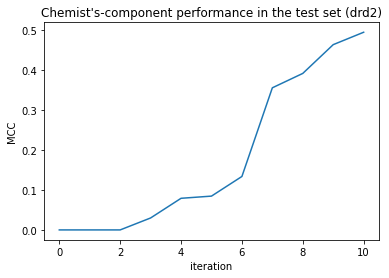

In [14]:
# Visualize performance of Chemist's component as predictive model in the test data
plt.plot(MCC)
plt.xlabel('iteration')
plt.ylabel('MCC')
plt.title("Chemist's-component performance in the test set (drd2)")

Text(0.5, 1.0, "Chemist's-component performance in the test set (drd2)")

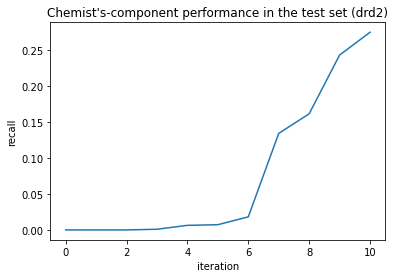

In [15]:
plt.plot(recall)
plt.xlabel('iteration')
plt.ylabel('recall')
plt.title("Chemist's-component performance in the test set (drd2)")

Text(0.5, 1.0, "Chemist's-component performance in the test set (drd2)")

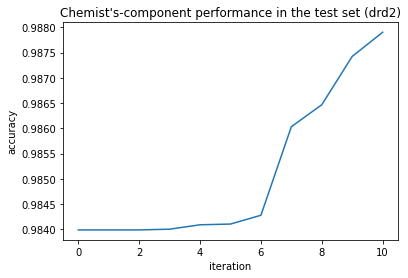

In [16]:
plt.plot(accuracy)
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.title("Chemist's-component performance in the test set (drd2)")

Text(0.5, 1.0, "Chemist's-component performance in the test set (drd2)")

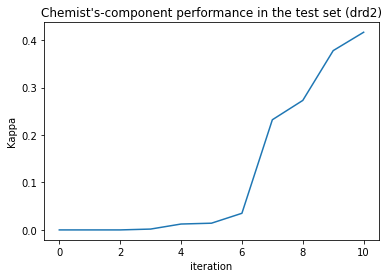

In [17]:
plt.plot(Kappa)
plt.xlabel('iteration')
plt.ylabel('Kappa')
plt.title("Chemist's-component performance in the test set (drd2)")